# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [3]:
energy = load_data('./data')[['load']]
energy.head(10)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"
2012-01-01 05:00:00,"2,453.00"
2012-01-01 06:00:00,"2,560.00"
2012-01-01 07:00:00,"2,719.00"
2012-01-01 08:00:00,"2,916.00"
2012-01-01 09:00:00,"3,105.00"


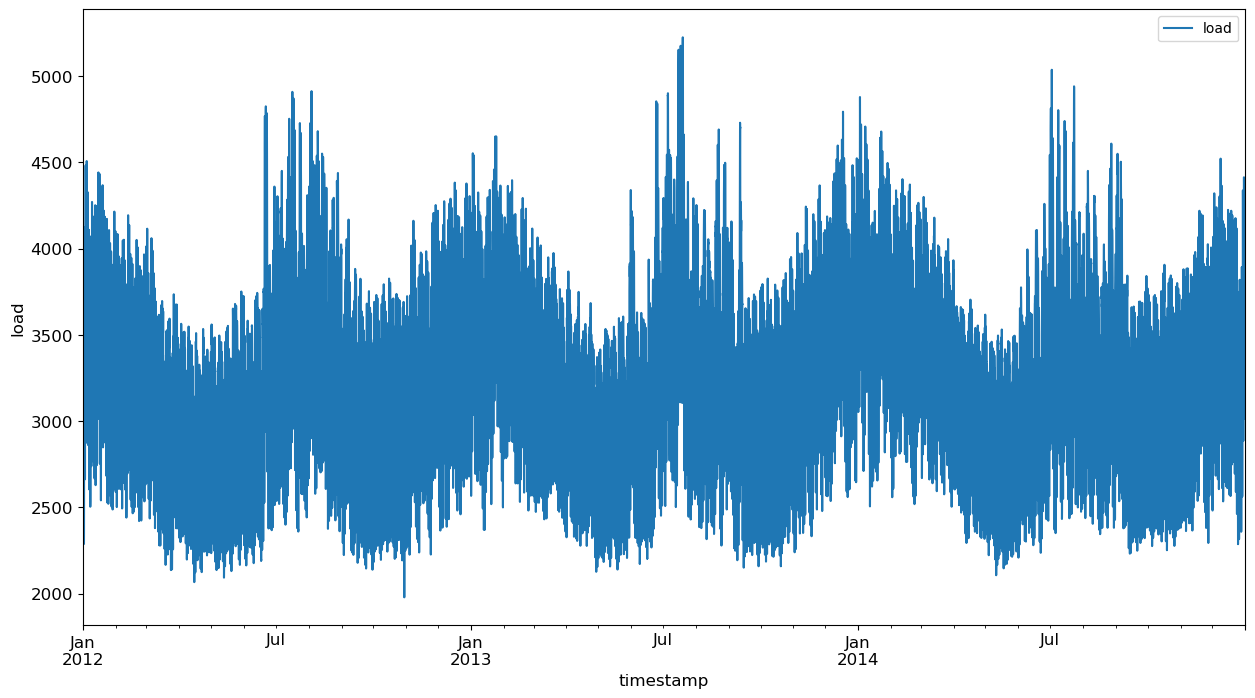

In [4]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Create training and testing datasets

In [5]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'

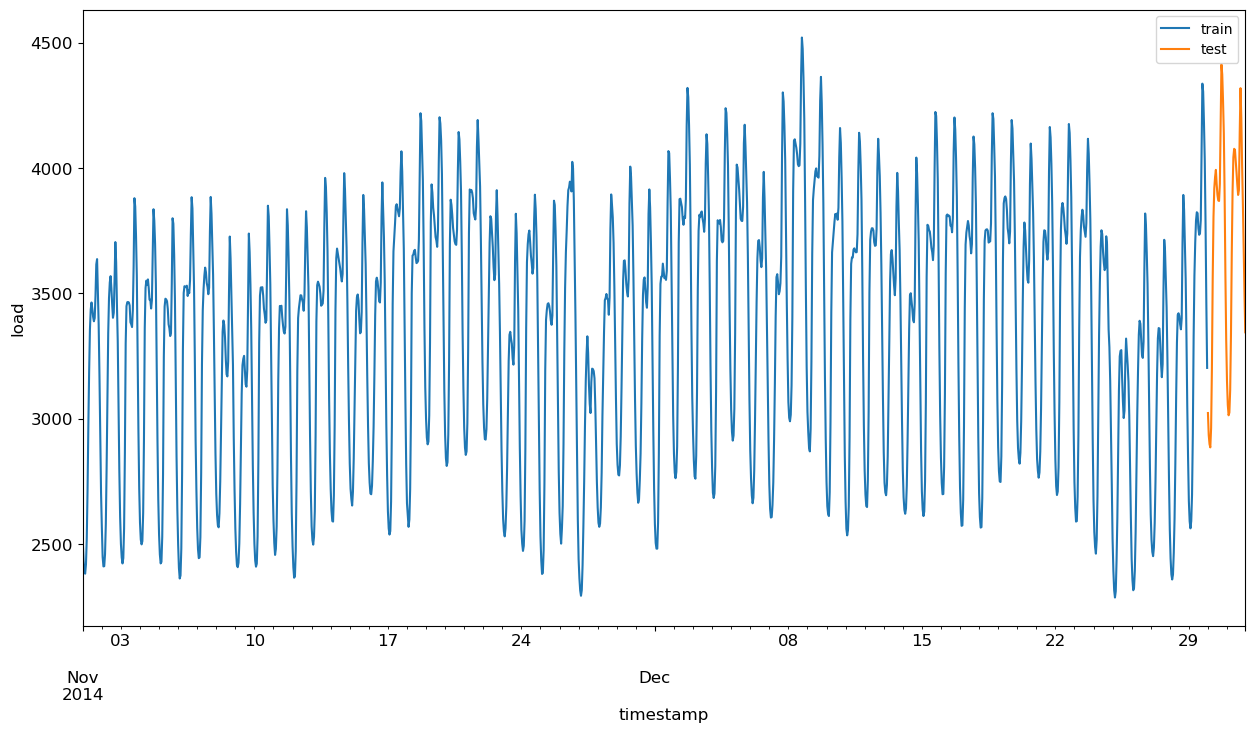

In [6]:
# puissant ici pour créer en une commande une séparation des données à dessiner, ne =modifie pas le df
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [11]:
train = energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy[(energy.index >= test_start_dt)][['load']]
print('Train data :', train.shape)
print('Test data :', test.shape)

Train data : (1416, 1)
Test data : (48, 1)


In [13]:
# Scale the data in the range(0,1)
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
test['load'] = scaler.transform(test)

## ARIMA forecasting

In [14]:
# Specify the number of steps to forecast ahead
HORIZON = 3  # hours
# p, d, q parameters
order = (4, 1, 0)
# P, D, Q seasonal parameters
seasonal_order = (1, 1, 0, 24)
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45390D+00    |proj g|=  4.12148D-01

At iterate   10    f= -2.45531D+00    |proj g|=  1.74062D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.45566D+00    |proj g|=  4.90525D-03

At iterate   20    f= -2.45568D+00    |proj g|=  2.64640D-02
  ys=-9.879E-11  -gs= 1.589E-10 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     81      2     1     0   2.751D-02  -2.456D+00
  F =  -2.4556777948411277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.240
Date:                            Fri, 28 Jun 2024   AIC                          -6942.480
Time:                                    14:22:31   BIC    

In [21]:
test_shifted = test.copy()

for t in range(1, HORIZON+1):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load,load+1,load+2,load+3
2014-12-30 00:00:00,"3,023.00","2,935.00","2,899.00","2,886.00"
2014-12-30 01:00:00,"2,935.00","2,899.00","2,886.00","2,963.00"
2014-12-30 02:00:00,"2,899.00","2,886.00","2,963.00","3,199.00"
2014-12-30 03:00:00,"2,886.00","2,963.00","3,199.00","3,558.00"
2014-12-30 04:00:00,"2,963.00","3,199.00","3,558.00","3,806.00"


In [22]:
%%time
training_window = 720  # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41942D+00    |proj g|=  1.50341D+00


 This problem is unconstrained.



At iterate    5    f= -2.41973D+00    |proj g|=  5.41394D-01

At iterate   10    f= -2.42221D+00    |proj g|=  1.24200D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.42275D+00    |proj g|=  1.97028D-01

At iterate   20    f= -2.42283D+00    |proj g|=  4.78072D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24    104      3     0     0   1.764D-02  -2.423D+00
  F =  -2.4228380712269884     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [3023.0000000000005, 2935.0000000000005, 2899.0000000000005, 2886.0000000000005]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94696D+00    |proj g|=  1.40992D-05


 This problem is unconstrained.



At iterate    5    f=  5.94696D+00    |proj g|=  2.83408D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   6.426D-06   5.947D+00
  F =   5.9469582209182956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2014-12-30 01:00:00
2 : predicted = [3002.99 2993.98 2994.11] expected = [2935.0000000000005, 2899.0000000000005, 2886.0000000000005, 2963.0000000000005]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94737D+00    |

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      7      1     0     0   4.166D-05   5.947D+00
  F =   5.9469596161237330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 02:00:00
3 : predicted = [2937.   2936.97 2937.02] expected = [2899.0000000000005, 2886.0000000000005, 2963.0000000000005, 3199.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94696D+00    |proj g|=  4.38312D-05

           * * *

Tit   = total number o

 This problem is unconstrained.


2014-12-30 03:00:00
4 : predicted = [2901.18 2901.62 2901.69] expected = [2886.0000000000005, 2963.0000000000005, 3199.000000000001, 3558.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94697D+00    |proj g|=  4.37518D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.419D-05   5.947D+00
  F =   5.9469728869033700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 04:00:00
5 : predicted = [2886.88 2887.12 2887.28] expected = [2963.0000000000005, 3199.000000000001, 3558.000000000001, 3806.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94728D+00    |proj g|=  4.38942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.418D-05   5.947D+00
  F =   5.9472788388845297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 05:00:00
6 : predicted = [2961.04 2960.28 2960.44] expected = [3199.000000000001, 3558.000000000001, 3806.000000000001, 3920.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95026D+00    |proj g|=  4.11957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.410D-05   5.950D+00
  F =   5.9502570348058246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 06:00:00
7 : predicted = [3191.77 3188.98 3189.21] expected = [3558.000000000001, 3806.000000000001, 3920.000000000001, 3965.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95720D+00    |proj g|=  3.15894D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.393D-05   5.957D+00
  F =   5.9571964242237758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 07:00:00
8 : predicted = [3549.46 3546.15 3546.34] expected = [3806.000000000001, 3920.000000000001, 3965.000000000001, 3993.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96052D+00    |proj g|=  2.38554D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.850D-05   5.961D+00
  F =   5.9605203821117305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 08:00:00
9 : predicted = [3803.05 3802.35 3802.38] expected = [3920.000000000001, 3965.000000000001, 3993.000000000001, 3936.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96121D+00    |proj g|=  2.38384D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   5.144D-05   5.961D+00
  F =   5.9612082306306355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 09:00:00
10 : predicted = [3919.87 3920.05 3920.05] expected = [3965.000000000001, 3993.000000000001, 3936.000000000001, 3893.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96131D+00    |proj g|=  2.38360D-05

           * * *

Tit   = total number of 

 This problem is unconstrained.


2014-12-30 10:00:00
11 : predicted = [3965.13 3965.24 3965.22] expected = [3993.000000000001, 3936.000000000001, 3893.000000000001, 3871.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96135D+00    |proj g|=  2.38348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   4.909D-05   5.961D+00
  F =   5.9613516506247946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 11:00:00
12 : predicted = [3993.02 3993.08 3993.06] expected = [3936.000000000001, 3893.000000000001, 3871.000000000001, 3869.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96152D+00    |proj g|=  2.38308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   4.999D-05   5.962D+00
  F =   5.9615182787974756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 12:00:00
13 : predicted = [3936.28 3936.11 3936.12] expected = [3893.000000000001, 3871.000000000001, 3869.000000000001, 3937.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96161D+00    |proj g|=  2.38281D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   5.285D-05   5.962D+00
  F =   5.9616142377958141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 13:00:00
14 : predicted = [3893.01 3892.9  3892.92] expected = [3871.000000000001, 3869.000000000001, 3937.000000000001, 4181.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96164D+00    |proj g|=  2.38276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   5.265D-05   5.962D+00
  F =   5.9616390452902994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 14:00:00
15 : predicted = [3870.97 3870.93 3871.06] expected = [3869.000000000001, 3937.000000000001, 4181.000000000001, 4413.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96164D+00    |proj g|=  2.38275D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   5.261D-05   5.962D+00
  F =   5.9616392440980173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 15:00:00
16 : predicted = [3868.97 3869.09 3869.21] expected = [3937.000000000001, 4181.000000000001, 4413.000000000001, 4374.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96188D+00    |proj g|=  2.38217D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   5.365D-05   5.962D+00
  F =   5.9618763123802587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 16:00:00
17 : predicted = [3936.87 3937.16 3937.14] expected = [4181.000000000001, 4413.000000000001, 4374.000000000001, 4270.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96492D+00    |proj g|=  2.37469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   7.048D-05   5.965D+00
  F =   5.9649178318020555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 17:00:00
18 : predicted = [4180.82 4181.41 4181.35] expected = [4413.000000000001, 4374.000000000001, 4270.000000000001, 4140.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96764D+00    |proj g|=  2.36801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   8.568D-05   5.968D+00
  F =   5.9676356288231860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 18:00:00
19 : predicted = [4414.9  4415.8  4415.74] expected = [4374.000000000001, 4270.000000000001, 4140.000000000001, 3895.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96772D+00    |proj g|=  2.36781D-05


 This problem is unconstrained.



At iterate    5    f=  5.96772D+00    |proj g|=  2.41877D-04

At iterate   10    f=  5.96772D+00    |proj g|=  2.27587D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.276D-06   5.968D+00
  F =   5.9677173820307239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2014-12-30 19:00:00
20 : predicted = [4374.55 4374.36 4374.25] expected = [4270.000000000001, 4140.000000000001, 3895.000000000001, 3571.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

 This problem is unconstrained.



At iterate    5    f=  5.96827D+00    |proj g|=  1.70925D-04

At iterate   10    f=  5.96827D+00    |proj g|=  3.85062D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.178D-06   5.968D+00
  F =   5.9682669505837120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2014-12-30 20:00:00
21 : predicted = [4269.55 4269.38 4269.23] expected = [4140.000000000001, 3895.000000000001, 3571.000000000001, 3313.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

 This problem is unconstrained.



At iterate    5    f=  5.96912D+00    |proj g|=  1.58784D-04

At iterate   10    f=  5.96911D+00    |proj g|=  1.12141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   2.016D-06   5.969D+00
  F =   5.9691134414259324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2014-12-30 21:00:00
22 : predicted = [4139.14 4138.85 4138.74] expected = [3895.000000000001, 3571.000000000001, 3313.000000000001, 3149.000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exa

 This problem is unconstrained.


2014-12-30 22:00:00
23 : predicted = [3892.39 3891.36 6914.18] expected = [3571.000000000001, 3313.000000000001, 3149.000000000001, 3055.0000000000005]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97722D+00    |proj g|=  2.34460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.344D-05   5.977D+00
  F =   5.9772157439431286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-30 23:00:00
24 : predicted = [3563.66 6583.58 6495.48] expected = [3313.000000000001, 3149.000000000001, 3055.0000000000005, 3014.0000000000005]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98027D+00    |proj g|=  3.40750D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1      3      1     0     0   2.337D-05   5.980D+00
  F =   5.9802711342474950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


2014-12-31 00:00:00
25 : predicted = [6324.69 6232.74 6196.49] expected = [3149.000000000001, 3055.0000000000005, 3014.0000000000005, 3025.0000000000005]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31784D+00    |proj g|=  4.60906D-01


 This problem is unconstrained.



At iterate    5    f=  6.10463D+00    |proj g|=  1.00127D-02

At iterate   10    f=  6.10351D+00    |proj g|=  7.27097D-03

At iterate   15    f=  6.04522D+00    |proj g|=  2.51755D-02

At iterate   20    f=  6.04416D+00    |proj g|=  2.55680D-02

At iterate   25    f=  6.01694D+00    |proj g|=  9.83853D-03

At iterate   30    f=  6.01686D+00    |proj g|=  3.26838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   3.268D-05   6.017D+00
  F =   6.0168553748882641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 01:00:00
26 : predicted = [3113.86 3094.

 This problem is unconstrained.



At iterate    5    f=  6.10545D+00    |proj g|=  1.29729D-02

At iterate   10    f=  6.10321D+00    |proj g|=  8.31406D-03

At iterate   15    f=  6.04525D+00    |proj g|=  6.92484D-03


LinAlgError: LU decomposition error.